In [1]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pickle
import scipy.stats as sc

In [2]:
# Set Variables
clustering="1"

basefolder = ""
plotsfolder = 'plots'
datafolder_true = "clustering"+clustering
datafolder_r = ""+clustering+"_r"

start_id = 1000
k = 11
nr_samples = 500
THETA = 0.5
tag = "clustering_"+clustering

In [3]:
# If code was already run before for that constellation of parameters:
#with open(os.path.join(datafolder_true, tag+'_distribution_theta'+str(THETA)+'.pkl'), 'rb') as f:
#    distribution = pickle.load(f)
#with open(os.path.join(datafolder_true, tag+'_distribution_theta'+str(THETA)+'_occur.pkl'), 'rb') as f:
#    occurences = pickle.load(f)
#with open(os.path.join(datafolder_true, tag+'distribution_theta'+str(THETA)+'_r.pkl'), 'rb') as f:
#    distribution_r = pickle.load(f)
#with open(os.path.join(datafolder_true, tag+'distribution_theta'+str(THETA)+'_r_occur.pkl'), 'rb') as f:
#    occurences_r = pickle.load(f)

In [4]:
# Get distribution of true data

TPs = []
all = []
for i in range(nr_samples):
    run_id = start_id+i
    for fold in range(5):
        filename = os.path.join(datafolder_true, str(run_id)+'_'+str(fold)+'_k'+str(k)+'_predictions.csv')
        try:
            predictions = pd.read_csv(filename)
            predictions['ID'] = predictions['v_b_gene']+predictions['j_b_gene']+predictions['cdr3_b_aa']
            P = predictions[predictions['labels'] == 1]
            TP = P[P['predictions'] > THETA]
            TPs.extend(TP['ID'])
            all.extend(P['ID'])
        except:
            #print(filename)
            break
distribution = Counter(TPs)
occurences = Counter(all)
with open(os.path.join(datafolder_true, tag+'_distribution_theta'+str(THETA)+'.pkl'), 'wb') as f:
    pickle.dump(distribution, f)
with open(os.path.join(datafolder_true, tag+'_distribution_theta'+str(THETA)+'_occur.pkl'), 'wb') as f:
    pickle.dump(occurences, f)

In [5]:
# Get distribution of randomized data

TPs = []
all = []
for i in range(nr_samples):
    run_id = start_id+i
    for fold in range(5):
        try:
            filename = os.path.join(datafolder_r, str(run_id)+'_'+str(fold)+'_k'+str(k)+'_predictions.csv')
            predictions = pd.read_csv(filename)
            predictions['ID'] = predictions['v_b_gene']+predictions['j_b_gene']+predictions['cdr3_b_aa']
            P = predictions[predictions['labels'] == 1]
            TP = P[P['predictions'] > THETA]
            TPs.extend(TP['ID'])
            all.extend(P['ID'])
        except:
            #print(filename)
            break
distribution_r = Counter(TPs)
occurences_r = Counter(all)

with open(os.path.join(datafolder_r, tag+'distribution_theta'+str(THETA)+'_r.pkl'), 'wb') as f:
    pickle.dump(distribution_r, f)
with open(os.path.join(datafolder_r, tag+'distribution_theta'+str(THETA)+'_r_occur.pkl'), 'wb') as f:
    pickle.dump(occurences_r, f)

In [6]:
# Correct distribution values to correct for different occurences of TCRs in random mode
def correct_distribution(distribution, occurences):
    corrected_distribution = {}
    for key in distribution.keys():
        corrected_distribution[key] = distribution[key]/occurences[key]*100
        if distribution[key] > occurences[key]:
            print(key)
    return corrected_distribution

distribution_corrected = correct_distribution(distribution, occurences)
distribution_r_corrected = correct_distribution(distribution_r, occurences_r)

# find cutoff
total_TP_random = len(distribution_r_corrected.values())
alpha = [0.05, 0.01, 0.001]
thresholds = []

def get_threshold(distribution, over_threshold):
    nr_samples = 0
    for cutoff in sorted(Counter(distribution.values()))[::-1]:
        nr_samples += Counter(distribution.values())[cutoff]
        if nr_samples >= over_threshold:
            return cutoff-1

for a in alpha:
    over_threshold = int(a*total_TP_random)
    thresholds.append(get_threshold(distribution_r_corrected, over_threshold))
thresholds

[57.333333333333336, 61.33766233766234, 66.05882352941175]

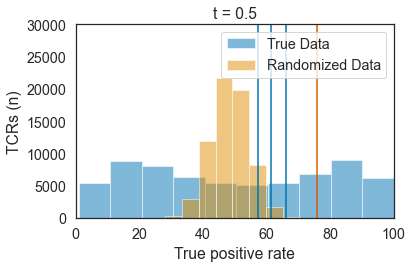

In [7]:
#Counter(distribution.values())
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)
plt.hist(distribution_corrected.values(), alpha=0.5, label='True Data')
plt.hist(distribution_r_corrected.values(), alpha=0.5, label='Randomized Data')

sc.mannwhitneyu([x for x in distribution_corrected.values()], [x for x in distribution_r_corrected.values()])

for t in thresholds:
    plt.vlines(t, ymin=0, ymax=30000)
plt.vlines(max(Counter(distribution_r_corrected.values()).keys()), ymin=0, ymax=30000, colors=['r'])
plt.ylim(0,30000)
plt.xlim(0,100)
plt.legend()
plt.title('t = '+str(THETA))
plt.ylabel('TCRs (n)')
plt.xlabel('True positive rate')
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, tag+'TP_distribution_theta'+str(THETA)+'.pdf'))

In [8]:
thresholds.append(max(Counter(distribution_r.values()).keys()))
for threshold in thresholds:
    TPs_over_threshold = [id for id in distribution_corrected.keys() if distribution_corrected[id] > threshold]
    print(threshold, len(TPs_over_threshold))

57.333333333333336 29211
61.33766233766234 27246
66.05882352941175 24783
63 26425
